##  Tool calling in a Graph
Build an agent using LangGraph and functions tooling.
We'll simply cycle between `2 nodes`:

- Our assistant node reasons and plans which tool to use
- Our tool node that executes the tool
- It will continue as long as our assistant is making a tool call.

### Schema:
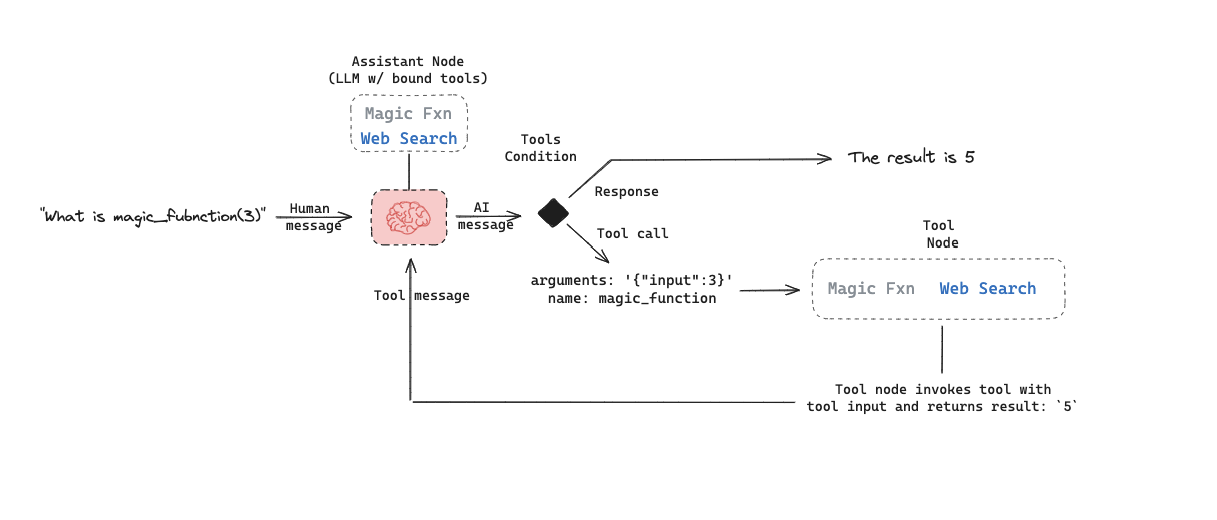



In [ ]:
import uuid
from typing import Annotated

from genai_tk.core.embeddings_factory import EmbeddingsFactory
from genai_tk.core.llm_factory import get_llm
from genai_tk.core.embeddings_store import EmbeddingsStore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.messages import ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
from langchain_core.tools import tool

# from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from rich import print
from typing_extensions import TypedDict

In [ ]:
llm = get_llm(llm_id=None)

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=0)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = EmbeddingsStore(
    id="Chroma_in_memory",
    table_name_prefix="training",
    embeddings_factory=EmbeddingsFactory(),
)

vectorstore.add_documents(doc_splits)

retriever = vectorstore.as_retriever(k=4)

In [ ]:
retriever.invoke("agent risks")

In [ ]:
@tool
def retrieve_documents(query: str) -> list:
    """Retrieve documents from the vector store based on the query."""
    return retriever.invoke(query)


@tool
def generate_answer(answer: str) -> str:
    """You are an assistant for question-answering tasks.
    Use the retrieved documents to answer the user question.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise.
    """
    return f"Here is the answer to the user question: {answer}"


@tool
def grade_document_retrieval(step_by_step_reasoning: str, score: int) -> str:
    """You are a teacher grading a quiz. You will be given:
    1/ a QUESTION
    2/ a set of comma separated FACTS provided by the student.

    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the FACTS are relevant to the QUESTION.
    A score of 0 means that NONE of the FACTS are relevant to the QUESTION.

    If your score is 1: then call a tool to generate the answer, generate_answer
    If your score is 0: then call a tool to perform web search, web_search.
    """
    if score == 1:
        return "Docs are relevant. Generate the answer to the question."
    return "Docs are not relevant. Use web search to find more documents."

In [ ]:
from genai_tk.tools.langchain.web_search_tool import basic_web_search

tools = [retrieve_documents, grade_document_retrieval, generate_answer, basic_web_search]

### Define the `Graph` and `Assistant` classes


In [ ]:
class Stater(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class Assistant:
    def __init__(self, runnable: Runnable) -> None:
        """Initialize the Assistant with a runnable object.

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: Stater, config: RunnableConfig):
        """Call method to invoke the LLM and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): The configuration for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """
        while True:
            result = self.runnable.invoke(state)  # Invoke the LLM
            if not result.tool_calls and (
                not result.content or isinstance(result.content, list) and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [ ]:
# Create the primary assistant prompt template

# llm = get_llm(llm_id="gpt_35_azure")
llm = get_llm(llm_id=None)
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            " You are a helpful assistant tasked with answering user questions using the provided vector store. "
            " Use the provided vector store to retrieve documents. Then grade them to ensure they are relevant before answering the question. ",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

### Memory

In [ ]:
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")


def handle_tool_error(state: Stater) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [ ]:
from IPython.display import Image
from langgraph.graph import START, StateGraph

# Graph
graph = StateGraph(Stater)

# Define nodes: these do the work
graph.add_node("assistant", Assistant(assistant_runnable))
graph.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
graph.add_edge(START, "assistant")
graph.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
graph.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state

# sqlite3_conn = sqlite3.connect("::memory", check_same_thread=False)
# sqlite3_memory_checkpoint = SqliteSaver(sqlite3_conn)

react_graph = graph.compile()


# react_graph = graph.compile(checkpointer=memory)
# react_graph = graph.compile(checkpointer=memory)


# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
def predict_react_agent_answer(example: dict):
    """Use this for answer evaluation."""
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    messages = react_graph.invoke({"messages": ("user", example["input"])}, config)
    return {"response": messages["messages"][-1].content, "messages": messages}

In [ ]:
user_query = {"input": "Let's talk about Task Decomposition?"}
response = predict_react_agent_answer(user_query)

In [ ]:
print(response)

In [ ]:
def find_tool_calls_react(messages):
    """Find all tool calls in the messages returned from the ReAct agent."""
    tool_calls = [tc["name"] for m in messages["messages"] for tc in getattr(m, "tool_calls", [])]
    return tool_calls

In [ ]:
find_tool_calls_react(response["messages"])